# Getting started

This example uses a custom class and custom function. See [custom steps](./writing-custom-steps.ipynb) for more details.

**In this section**
- [Steps](#steps)
- [Create a function](#create-a-function)
- [Build the graph](#build-the-graph)
- [Visualize the graph](#visualize-the-graph)
- [Test the function](#test-the-function)
- [Deploy the function](#deploy-the-function)
- [Test the deployed function](#test-the-deployed-function)

## Steps

The following code defines basic steps that illustrate building a graph. These steps are:

- **`inc`**: increments the value by 1.
- **`mul`**: multiplies the value by 2.
- **`WithState`**: class that increments an internal counter, prints an output, and adds the input value to the current counter.

In [1]:
# mlrun: start-code

def inc(x):
    return x + 1

def mul(x):
    return x * 2

class WithState:
    def __init__(self, name, context, init_val=0):
        self.name = name
        self.context = context
        self.counter = init_val

    def do(self, x):
        self.counter += 1
        print(f"Echo: {self.name}, x: {x}, counter: {self.counter}")
        return x + self.counter
    
# mlrun: end-code

## Create a function

Now take the code above and create an MLRun function called `serving-graph`.

In [2]:
import mlrun
fn = mlrun.code_to_function("simple-graph", kind="serving", image="mlrun/mlrun")
graph = fn.set_topology("flow")

## Build the graph

Use `graph.to()` to chain steps. Use `.respond()` to mark that the output of that step is returned to the caller
(as an http response). By default the graph is async with no response.

In [3]:
graph.to(name="+1", handler='inc')\
     .to(name="*2", handler='mul')\
     .to(name="(X+counter)", class_name='WithState').respond()

## Visualize the graph

Using the `plot` method, you can visualize the graph.

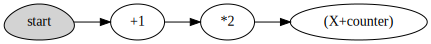

In [4]:
graph.plot(rankdir='LR')

## Test the function

Create a mock server and test the graph locally. Since this graph accepts a numeric value as the input, that value is provided 
in the `body` parameter.

In [5]:
server = fn.to_mock_server()
server.test(body=5)

Echo: (X+counter), x: 12, counter: 1


13

Run the function again. This time, the counter should be 2 and the output should be 14.

In [6]:
server.test(body=5)

Echo: (X+counter), x: 12, counter: 2


14

## Deploy the function

Use the `deploy` method to deploy the function.

In [7]:
fn.deploy(project='basic-graph-demo')

> 2021-11-08 07:30:21,571 [info] Starting remote function deploy
2021-11-08 07:30:21  (info) Deploying function
2021-11-08 07:30:21  (info) Building
2021-11-08 07:30:21  (info) Staging files and preparing base images
2021-11-08 07:30:21  (info) Building processor image
2021-11-08 07:30:26  (info) Build complete
2021-11-08 07:30:31  (info) Function deploy complete
> 2021-11-08 07:30:31,785 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-basic-graph-demo-simple-graph.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['basic-graph-demo-simple-graph-basic-graph-demo.default-tenant.app.aganefaibuzg.iguazio-cd2.com/']}


'http://basic-graph-demo-simple-graph-basic-graph-demo.default-tenant.app.aganefaibuzg.iguazio-cd2.com/'

## Test the deployed function

Use the `invoke` method to call the function.

In [8]:
fn.invoke('', body=5)

> 2021-11-08 07:30:43,241 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-basic-graph-demo-simple-graph.default-tenant.svc.cluster.local:8080/'}


13

In [9]:
fn.invoke('', body=5)

> 2021-11-08 07:30:48,359 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-basic-graph-demo-simple-graph.default-tenant.svc.cluster.local:8080/'}


14